#  FedAvg on MNIST
FedAvg implementation that trains a model using 3 clients, 10 communication rounds, 2 local epochs.

## Importing Libraries and Data

In [4]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

## Define The FCNN

In [ ]:
class MnistNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MnistNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, num_classes)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

## Define Client Class
A class to represent a single client, providing data generation, model training and model recieving/setting functionality. In a true FedAvg implementation the functionality of this class would operate on a seperate device and communicate via a network.

In [ ]:
class Client():
    def __init__(self, name, server):
        self.name = name
        self.server = server
        self.client_losses = []
        self.client_accuracies = []
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Client {self.name} created on {self.server.name}")

    def set_dataset(self, dataset):
        self.mnist_trainloader = torch.utils.data.DataLoader(
            dataset,
            batch_size=self.server.batch_size,
            shuffle=True,
            num_workers=2
        )
        
        print(f"Added {len(dataset)} MNIST datapoints to client {self.name} of {self.server.name}")

    def set_model(self, model):
        self.local_model = model
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.SGD(self.local_model.parameters(), lr=5e-3, momentum=0.9)

    def train(self):
        total_loss = 0
        total_batches = 0

        self.local_model.train()
        for epoch in range(self.server.local_epochs):
            for batch_idx, (data, targets) in enumerate(self.mnist_trainloader):
                data = data.to(self.server.device).reshape(data.shape[0], -1)
                targets = targets.to(self.server.device)
                scores = self.local_model(data)
                loss = self.criterion(scores, targets)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                total_loss += loss.item()
                total_batches += 1
        average_loss = total_loss / total_batches
        self.client_losses.append(average_loss)
        local_accuracy = self.get_local_model_accuracy()
        self.client_accuracies.append(local_accuracy)
        print(f"Client {self.name} trained with average loss: {average_loss:.4f} and accuracy: {local_accuracy}")
    
    def get_local_model_accuracy(self):
        self.test_accuracy = self.server.calculate_accuracy(self.server.mnist_testloader, self.local_model)
        return self.test_accuracy

## Define Server Class
Define a class to represent the centeral server, providing client and model management functionality.

In [ ]:
class Server():
    def __init__(self, name, global_model = None):
        self.name = name
        self.clients = []
        self.global_model = global_model
        self.transform = transforms.Compose([transforms.ToTensor(), 
                                             transforms.Normalize((0.5,), (0.5,))])
        self.mnist_classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')
        self.batch_size = 32
        self.local_epochs = 2
        self.communication_rounds = 10
        self.global_accuracy = []
        self.average_accuracy = []
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def set_global_model(self, global_model):
        self.global_model = global_model

    def add_clients(self, client_amount):
        for i in range(client_amount):
            self.clients.append(Client(len(self.clients) + 1, self))

    def set_clients_model(self):
        for client in self.clients:
            client_model = MnistNN(input_size=784, num_classes=10).to(self.device)
            client_model.load_state_dict(self.global_model.state_dict().copy())
            client.set_model(client_model)
        print(f"All {self.name} clients set to global model")
        print()

    def generate_clients_mnist_data(self):
        '''
        Splits the mnist dataset equally among all clients
        '''
        dataset = datasets.MNIST(root='../data', train=True,
                                download=True, transform=self.transform)
        
        total_size = len(dataset)
        num_clients = len(self.clients)
        split_size = total_size // num_clients
        
        print(f"Dividing {total_size} samples among {num_clients} clients (~{split_size} samples each)")
        indices = torch.randperm(total_size)
        
        client_indices = []
        for i in range(num_clients):
            start_idx = i * split_size
            end_idx = (i + 1) * split_size if i < num_clients - 1 else total_size
            client_indices.append(indices[start_idx:end_idx])
        
        for i, client in enumerate(self.clients):
            client_dataset = torch.utils.data.Subset(dataset, client_indices[i])
            client.set_dataset(client_dataset)

    def train_clients_round(self):
        for client in self.clients:
            client.train()

    def build_converged_model(self):
        """
        Create a new global model by averaging all client models' parameters
        """
    
        first_client_dict = self.clients[0].local_model.state_dict()

        averaged_state_dict = {}
        for parameter_name in first_client_dict.keys():
            client_parameters = []
            for client in self.clients:
                client_state_dict = client.local_model.state_dict()
                client_parameters.append(client_state_dict[parameter_name])
            
            stacked_parameters = torch.stack(client_parameters, dim=0)
            averaged_parameters = torch.mean(stacked_parameters, dim=0)
            
            averaged_state_dict[parameter_name] = averaged_parameters
        
        converged_model = MnistNN(input_size=784, num_classes=10).to(self.device)
        converged_model.load_state_dict(averaged_state_dict)
        
        print(f"Successfully converged models from {len(self.clients)} clients")
        return converged_model

    def converge_client_models(self):
        new_global_model = self.build_converged_model()
        self.set_global_model(new_global_model)            

    def fed_avg(self, communication_rounds):
        self.communication_rounds = communication_rounds
        print(f"Training {len(self.clients)} clients on {self.name} with hyperparameters of {self.batch_size} batch size, {self.local_epochs} local epochs and {self.communication_rounds} communication rounds")
        for round in range(self.communication_rounds):
            self.set_clients_model()
            self.train_clients_round()
            average_model_accuracy = self.test_client_models()
            self.average_accuracy.append(average_model_accuracy)

            self.converge_client_models()
            global_model_accuracy = self.calculate_accuracy(self.mnist_testloader, self.global_model)
            self.global_accuracy.append(global_model_accuracy)

            print(f"Round {round + 1} complete:")
            print(f"Average client model accuracy (before convergence): {average_model_accuracy}")
            print(f"Global model accuracy (After convergence): {global_model_accuracy}")
            print()
        
        self.set_clients_model()
        print("Final round complete - all clients updated with converged model")

    def load_test_loader(self):
        self.mnist_testset = datasets.MNIST(root='../data', train=False,
                                                        download=True, transform=self.transform)
        self.mnist_testloader = torch.utils.data.DataLoader(self.mnist_testset, batch_size=self.batch_size,
                                                            shuffle=False, num_workers=2)
        
    def calculate_accuracy(self, loader, model):
        number_correct = 0
        number_samples = 0
        model.eval()

        with torch.no_grad():
            for x, y in loader:
                x = x.to(self.device).reshape(x.shape[0], -1)
                y = y.to(self.device)
                scores = model(x)
                _, predictions = scores.max(1)
                number_correct += (predictions == y).sum()
                number_samples += predictions.size(0)
        model.train()
        return number_correct / number_samples
        
    def test_client_models(self):
        '''
        Calculates the average accuracy of all the client models
        '''
        client_accuracy_average = 0
        for client in self.clients:
            client_accuracy = client.get_local_model_accuracy()
            client_accuracy_average += client_accuracy
        average_accuracy = client_accuracy_average / len(self.clients)
        return average_accuracy

## Load and Split Training Data
Use the class defined functions to initalise a server, add clients to the server and generate MNIST data for each client.

In [8]:
mnist_server = Server("mnist_server")

mnist_server.add_clients(3)

mnist_server.generate_clients_mnist_data()

Client 1 created on mnist_server
Client 2 created on mnist_server
Client 3 created on mnist_server
Dividing 60000 samples among 3 clients (~20000 samples each)
Added 20000 MNIST datapoints to client 1 of mnist_server
Added 20000 MNIST datapoints to client 2 of mnist_server
Added 20000 MNIST datapoints to client 3 of mnist_server


## Initalise Server Model
Create an instance of the model and add it to the server

In [ ]:
model =  MnistNN(input_size=784, num_classes=10).to(mnist_server.device)
print(f"Model: {model}")
mnist_server.set_global_model(model)

Model: MinstNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


## Test Untrained Model
Load the test loader and test the untrained model to compare the accuracy later

In [10]:
mnist_server.load_test_loader()
global_accuracy_untrained = mnist_server.calculate_accuracy(mnist_server.mnist_testloader, mnist_server.global_model)
print(f"Global model accuracy before training: {global_accuracy_untrained}")

Global model accuracy before training: 0.08630000054836273


## Run FedAvg Algorithm
Run the FedAvg algorithm for ten communication rounds

In [11]:
print(f"Training with device: {mnist_server.device}")
mnist_server.fed_avg(10)

Training with device: cuda
Training 3 clients on mnist_server with hyperparameters of 32 batch size, 2 local epochs and 10 communication rounds
All mnist_server clients set to global model

Client 1 trained with average loss: 0.7339 and accuracy: 0.923799991607666
Client 2 trained with average loss: 0.7119 and accuracy: 0.9125999808311462
Client 3 trained with average loss: 0.7204 and accuracy: 0.9088999629020691
Successfully converged models from 3 clients
Round 1 complete:
Average client model accuracy (before convergence): 0.9151000380516052
Global model accuracy (After convergence): 0.9258999824523926

All mnist_server clients set to global model

Client 1 trained with average loss: 0.3032 and accuracy: 0.927299976348877
Client 2 trained with average loss: 0.2948 and accuracy: 0.9422000050544739
Client 3 trained with average loss: 0.2935 and accuracy: 0.9434999823570251
Successfully converged models from 3 clients
Round 2 complete:
Average client model accuracy (before convergence)

## Test Global Model

In [12]:
global_accuracy_trained = mnist_server.calculate_accuracy(mnist_server.mnist_testloader, mnist_server.global_model)
print(f"Global Model Accuracy After Training: {global_accuracy_trained}")

Global Model Accuracy After Training: 0.9774999618530273


## Results

In [ ]:
print(f"{mnist_server.name} with {len(mnist_server.clients)} clients FedAvg results:")
print(f"Global model accuracy before training: {global_accuracy_untrained}")
print(f"Global model accuracy after training: {global_accuracy_trained}")

mnist_server with 3 results:
Global model accuracy before training: 0.08630000054836273
Global model accuracy after training: 0.9774999618530273


## Convergence Analysis - Plot Average Client Accuracy and Global Model Accuracy
Compare the average client accuracy with the global model accuracy to derive convergence insights

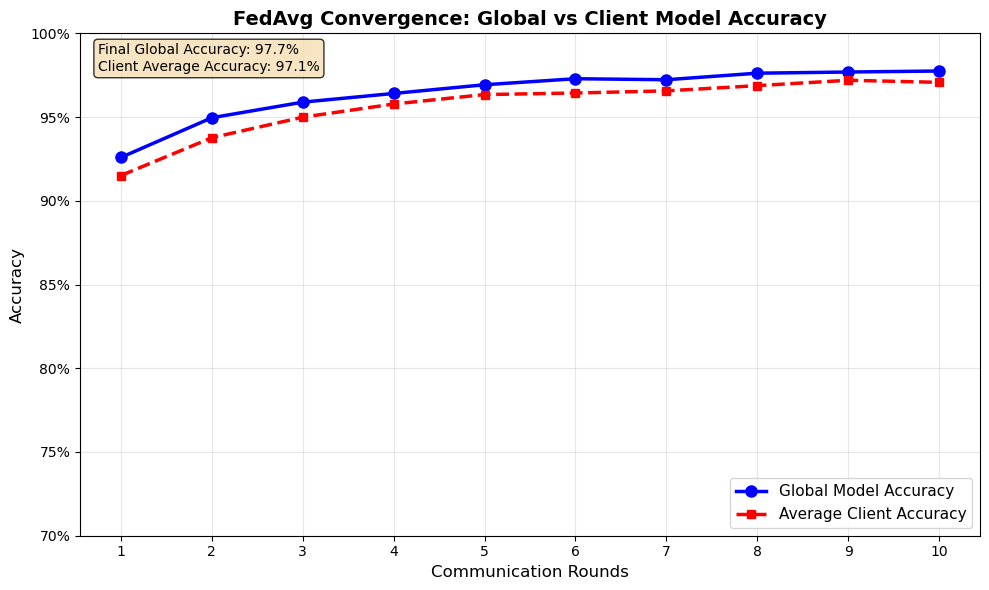

In [14]:
plt.figure(figsize=(10, 6))

global_accuracy_cpu = [acc.cpu().item() if torch.is_tensor(acc) else acc for acc in mnist_server.global_accuracy]
average_accuracy_cpu = [acc.cpu().item() if torch.is_tensor(acc) else acc for acc in mnist_server.average_accuracy]

rounds = range(1, len(global_accuracy_cpu) + 1)
plt.plot(rounds, global_accuracy_cpu, 'b-', linewidth=2.5, marker='o', markersize=8, label='Global Model Accuracy')
plt.plot(rounds, average_accuracy_cpu, 'r--', linewidth=2.5, marker='s', markersize=6, label='Average Client Accuracy')

plt.xlabel('Communication Rounds', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('FedAvg Convergence: Global vs Client Model Accuracy', fontsize=14, fontweight='bold')
plt.legend(fontsize=11, loc='lower right')
plt.grid(True, alpha=0.3)
plt.xticks(rounds)

plt.ylim(0.7, 1.0)
plt.yticks([0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0])
plt.gca().set_yticklabels(['70%', '75%', '80%', '85%', '90%', '95%', '100%'])

final_global_acc = global_accuracy_cpu[-1]
final_avg_acc = average_accuracy_cpu[-1]

textstr = f'Final Global Accuracy: {final_global_acc:.1%}\nClient Average Accuracy: {final_avg_acc:.1%}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
plt.text(0.02, 0.98, textstr, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

## Plot Client Loss During Training
Show the accuracy over rounds to track the model improvements

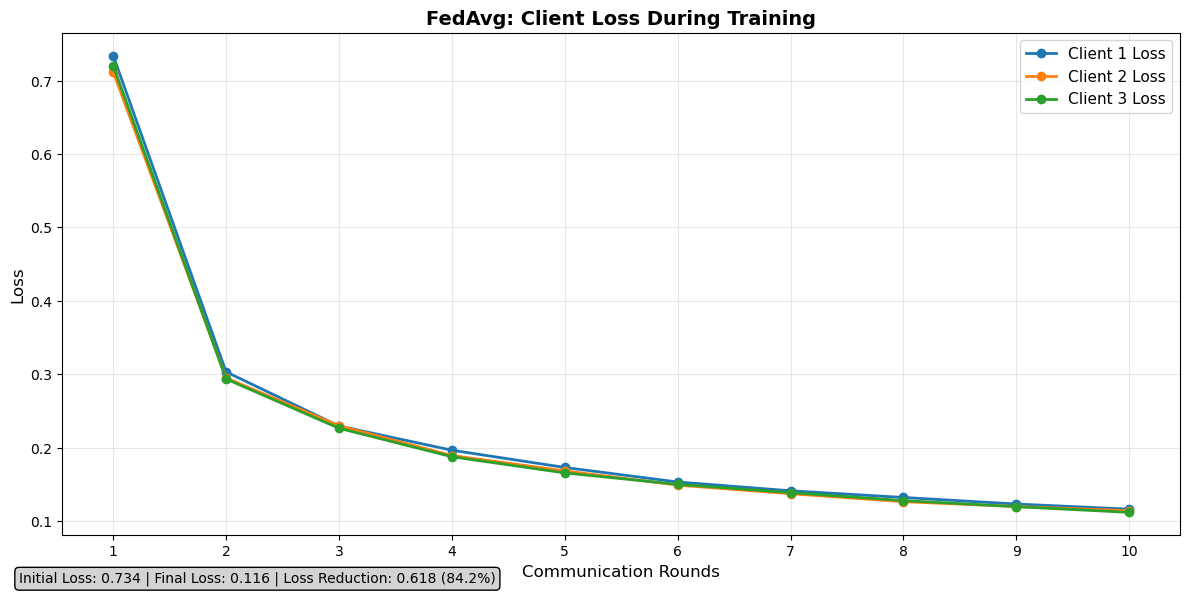

In [20]:
plt.figure(figsize=(12, 6))

rounds = range(1, len(mnist_server.clients[0].client_losses) + 1)

for client in mnist_server.clients:
    losses_cpu = [loss.cpu().item() if torch.is_tensor(loss) else loss for loss in client.client_losses]
    plt.plot(rounds, losses_cpu, linewidth=2, marker='o', 
             label=f'Client {client.name} Loss')

plt.xlabel('Communication Rounds', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('FedAvg: Client Loss During Training', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(rounds)

initial_loss = mnist_server.clients[0].client_losses[0]
final_loss = mnist_server.clients[0].client_losses[-1]

if torch.is_tensor(initial_loss):
    initial_loss = initial_loss.cpu().item()
if torch.is_tensor(final_loss):
    final_loss = final_loss.cpu().item()

loss_reduction = initial_loss - final_loss

plt.figtext(0.02, 0.02, f'Initial Loss: {initial_loss:.3f} | '
                            f'Final Loss: {final_loss:.3f} | '
                            f'Loss Reduction: {loss_reduction:.3f} ({loss_reduction/initial_loss:.1%})', 
            fontsize=10, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))

plt.tight_layout()
plt.show()